In [19]:
import data.transform
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data.dataset import MetaDataset
from env import sr, frame_size
from loss import MSE, MelMSE, MelMeanFilteredMSE, MelGaussianFilteredMSE
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
from models import save_model, load_model
from models.vae import ToyVAE, MultiFeaturePerceptron, CustomModel
from maml import reptile_train
import data
import data.transform
from data import read_audio, AudioData
from data.transform import log_stft, db_to_amp
from data.dataset import (
    TaskDataset, InputData,
    from_gen_model_output, to_gen_model_output)
from visualization import plot_spec
from vocoder import griffin_lim
from utils import get_model_param_count

plt.style.use({'figure.facecolor':'white'})

In [21]:
def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

In [22]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()

# Train formant encoder/decoder

In [23]:
from models.split_model import FormantCoder, FormantCoderDataset

In [24]:
formant_coder_dataset = FormantCoderDataset(VCC2016TrainAppendedMetadata())
print('Formant coder data loaded', datetime.now())

Formant coder data loaded 2021-11-30 20:50:51.347415


In [25]:
device = torch.device('cuda')
formant_coder = FormantCoder().to(device)

# criterion = MSE()
formant_coder_criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = MelMSE(is_input_log_amp=True, n_mel=512)
# criterion = MelMeanFilteredMSE(max_filter_size=10)
# criterion = MelGaussianFilteredMSE(max_filter_size=8)
if isinstance(formant_coder_criterion, nn.Module):
    criterion = formant_coder_criterion.to(device)

formant_coder_optimizer = optim.Adam(
    formant_coder.parameters(), lr=1e-3, weight_decay=0)

In [26]:
def train_formant_coder(
        model, n_iter=1000, log_period=10, test_proportion=0.3):
    model.train()
    for i in range(n_iter):
        idx = np.random.randint(formant_coder_dataset.n_audios)
        x = torch.from_numpy(formant_coder_dataset[idx].astype(np.float32))
        x = x.transpose(0, 1)
        x = x.to(device)
        if test_proportion is None or test_proportion == 0:
            train_x = x
        else:
            test_indices = np.random.choice(x.shape[0],
                                            int(x.shape[0] * test_proportion))
            mask = np.zeros(x.shape[0], dtype=bool)
            mask[test_indices] = True
            test_x = x[mask]
            train_x = x[~mask]
        formant_coder_optimizer.zero_grad()
        out = model(train_x)
        loss = criterion(out[:, :], train_x[:, :])
        loss.backward()
        formant_coder_optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', loss.item(), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    loss = criterion(out[:, :], test_x[:, :])
                    print('; Test', i, ': ', loss.item(), end='')
            print()
train_formant_coder(formant_coder)
save_model('saved_models/' +
           type(formant_coder).__name__ + '.pt', formant_coder)

Pass 0 :  3433.862548828125; Test 0 :  3148.890380859375
Pass 10 :  3382.811767578125; Test 10 :  2819.75537109375
Pass 20 :  3492.576416015625; Test 20 :  3317.325439453125
Pass 30 :  3033.490966796875; Test 30 :  2783.634033203125
Pass 40 :  3576.30810546875; Test 40 :  3004.51708984375
Pass 50 :  3257.691162109375; Test 50 :  2964.595703125
Pass 60 :  3179.663330078125; Test 60 :  3543.71630859375
Pass 70 :  3197.51025390625; Test 70 :  3245.58544921875
Pass 80 :  2825.526123046875; Test 80 :  2906.880126953125
Pass 90 :  2552.028076171875; Test 90 :  2523.87841796875
Pass 100 :  2746.63427734375; Test 100 :  2646.585693359375
Pass 110 :  2669.167236328125; Test 110 :  3054.37744140625
Pass 120 :  2926.5927734375; Test 120 :  2795.043212890625
Pass 130 :  2167.723388671875; Test 130 :  2305.516357421875
Pass 140 :  2559.575927734375; Test 140 :  2252.1552734375
Pass 150 :  2066.775634765625; Test 150 :  2550.2666015625
Pass 160 :  2540.191650390625; Test 160 :  2276.95166015625
Pass

Original


Reconstructed


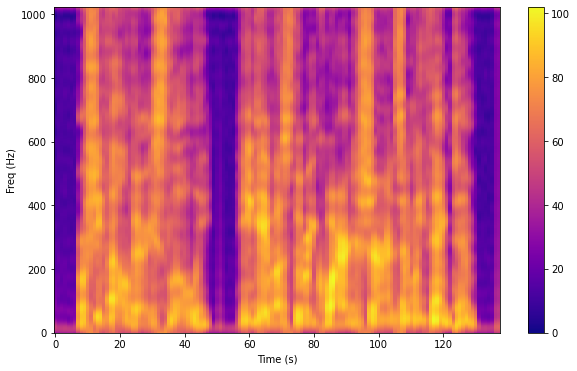

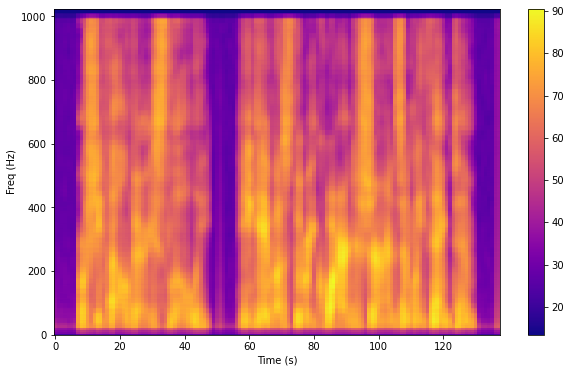

In [27]:
# test formant coder
with torch.no_grad():
    idx = 10
    x = formant_coder_dataset[idx]
    amp = formant_coder_dataset.all_audios[idx].amp
    sound(griffin_lim(amp), label='Original')
    lo, hi = data.transform.dft_filter(log_stft(amp))
    plot_spec(x)
    x = torch.from_numpy(x.astype(np.float32))
    x_recon = formant_coder(x.transpose(0, 1).to(device)).detach().cpu().numpy().T
    sound(griffin_lim(db_to_amp(x_recon+hi)), label='Reconstructed')
    plot_spec(x_recon)

# Train Formant transformer

In [76]:
from models.split_model import FormantTransformer, SplitModelMetaDataset

formant_coder = load_model('saved_models/' +
           type(formant_coder).__name__ + '.pt', FormantCoder).to(device)

In [29]:
dataset = SplitModelMetaDataset(meta_data)
dataset.read_and_preprocess()
print('Split meta data loaded', datetime.now())

Split meta data loaded 2021-11-30 20:55:27.698887


In [77]:
class OptimizerMgr:
    def __init__(self):
        self.instance = None
    def create_instance(self, model):
        # self.instance = optim.SGD(model.parameters(),
        #                           lr=1e-3, weight_decay=0) # 2e-4
        # self.instance = optim.Adam(model.parameters(),
        #                            lr=1e-5, weight_decay=0)
        self.instance = optim.Adam(model.parameters(),
                                   lr=1e-3, weight_decay=0)

    def get(self):
        return self.instance

formant_transformer_optimizer_mgr = OptimizerMgr()

In [84]:
def train_formant_transformer(model, x, y,
          n_iter=1000, log_period=None, test_proportion=0.2):
    # optimizer_mgr.create_instance(model)
    optimizer = formant_transformer_optimizer_mgr.get()
    model.train()
    # x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    if test_proportion is None or test_proportion == 0:
        train_x, train_y = x, y
    else:
        test_indices = np.random.choice(x.shape[0],
                                        int(x.shape[0] * test_proportion))
        mask = np.zeros(x.shape[0], dtype=bool)
        mask[test_indices] = True
        test_x, test_y = x[mask], y[mask]
        train_x, train_y = x[~mask], y[~mask]
        with torch.no_grad():
            test_y_decoded = formant_coder.decode(test_y)
    with torch.no_grad():
        train_y_decoded = formant_coder.decode(train_y)
    for i in range(n_iter):
        optimizer.zero_grad()
        out = model(train_x)
        # loss = criterion(out[:, :], train_y[:, :])
        loss = criterion(formant_coder.decode(out), train_y_decoded)

        loss.backward()
        optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', loss.item(), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    # loss = criterion(out[:, :], test_y[:, :])
                    loss = criterion(formant_coder.decode(out), test_y_decoded)
                    print('; Test', i, ': ', loss.item(), end='')
            print()

In [85]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

# def learnable_test(model, train_source_filename, train_target_filename,
#                    vocode=True):
#     from data.dataset import to_gen_model_output
#     def plot_selected_frames(selected_frames):
#         plt.twinx()
#         plt.scatter(np.arange(selected_frames.size), selected_frames)
#
#     task_dat = TaskDataset(train_source_filename, train_target_filename)
#     # plot raw spec
#     plot_spec(to_gen_model_output(task_dat.source.amp), title='Source train',
#               figure_size=(10,10))
#     plot_selected_frames(task_dat.source.selected_frames)
#     plot_spec(to_gen_model_output(task_dat.target.amp), title='Target train',
#               figure_size=(10,10))
#     plot_selected_frames(task_dat.target.selected_frames)
#     # plot aligned spec
#     amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
#     plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
#               figure_size=(10,10))
#     plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
#           figure_size=(10,10))
#     if vocode:
#         sound(griffin_lim(amp_x_aligned), label='Source train aligned')
#         sound(griffin_lim(amp_y_aligned), label='Target train aligned')
#     # train
#     train_x, train_y = task_dat.get()
#     formant_transformer_optimizer_mgr.create_instance(model)
#     train_formant_transformer(model,
#           torch.from_numpy(train_x.astype(np.float32)),
#           torch.from_numpy(train_y.astype(np.float32)),
#           n_iter=5000, log_period=200, test_proportion=0.2) # TODO: tune this
#     # test with train dataset
#     estimated = model(torch.from_numpy(train_x).transpose(0, 1).to(device))
#     raw_estimated = estimated.detach().cpu().numpy().T
#     y = from_gen_model_output(estimated).detach().cpu().numpy().T
#     # if isinstance(criterion, MelMSE):
#     #     mel_y = criterion.mel(estimated.T).detach().cpu().numpy()
#     #     mel_target = criterion.mel(
#     #         torch.from_numpy(train_y.astype(np.float32)).to(device)
#     #     ).detach().cpu().numpy()
#     #     plot_spec(mel_y, title='mel y',figure_size=(10,10))
#     #     plot_spec(mel_target, title='mel target',figure_size=(10,10))
#     plot_spec(log_stft(y), title='Test output',figure_size=(10,10))
#     plot_spec(train_y[:frame_size], title='Test target env',
#               figure_size=(10,10))
#     plot_spec(raw_estimated[:frame_size], title='output env',
#               figure_size=(10,10))
#     plot_spec(train_y[frame_size:], title='Test target freq',
#               figure_size=(10,10))
#     plot_spec(raw_estimated[frame_size:], title='output freq',
#               figure_size=(10,10))
#     if vocode:
#         sound(griffin_lim(y), label='Test estimate')
#
# learnable_test(model, meta_data.get(3, 0), meta_data.get(0, 0))


'\nThis code block tests whether a model is "learnable" for a certain task\nIt simply fixes a single task and trains the model, and then it checks\nmodel performance w.r.t. train set.\n'

In [86]:
from copy import deepcopy

# Meta train

formant_transformer = FormantTransformer().to(device)
formant_transformer_optimizer_mgr.create_instance(formant_transformer)

def reptile_train(model, meta_dataset: SplitModelMetaDataset, n_shot,
                  n_iter_meta, meta_step_size,
                  inner_train_func, n_iter_inner=1000,
                  log_period_meta=10, log_period_inner=250, **kwargs):
    def to_lo(log_amp):
        lo, hi = data.transform.dft_filter(log_amp)
        return lo
    # Reptile training loop
    for iteration in range(n_iter_meta):
        should_log = (log_period_meta is not None
                      and iteration % log_period_meta == 0)
        inner_log_period = log_period_inner if should_log else None
        weights_before = deepcopy(model.state_dict())
        # Generate task
        x, x_indices, y, y_indices = meta_dataset.sample()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y = to_lo(x), to_lo(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        y = torch.from_numpy(y.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            y = formant_coder.encode(y)
        # Do optimization on this task
        if should_log:
            print('Meta iter', iteration, ': ')
        inner_train_func(model, x, y, n_iter=n_iter_inner,
                         log_period=inner_log_period, **kwargs)
        # Interpolate between current weights and trained weights from this task
        # I.e. (weights_before - weights_after) is the meta-gradient
        weights_after = model.state_dict()
        step_size = meta_step_size * (
                1 - iteration / n_iter_meta)  # linear schedule
        model.load_state_dict(
            {name: weights_before[name] + (weights_after[name] -
                                           weights_before[name]) * step_size
             for name in weights_before})


reptile_train(formant_transformer, dataset, n_shot=None,
              n_iter_meta=1000, meta_step_size=5e-2,
              inner_train_func=train_formant_transformer, n_iter_inner=10,
              log_period_meta=50, log_period_inner=2)

save_model('saved_models/' + type(formant_transformer).__name__ + '.pt',
           formant_transformer)

Meta iter 0 : 
Pass 0 :  2853.11083984375; Test 0 :  2432.50390625
Pass 2 :  2206.583740234375; Test 2 :  2266.360595703125
Pass 4 :  2025.0794677734375; Test 4 :  2042.586669921875
Pass 6 :  1769.8721923828125; Test 6 :  1730.2196044921875
Pass 8 :  1421.215087890625; Test 8 :  1318.5335693359375
Meta iter 50 : 
Pass 0 :  97.2733154296875; Test 0 :  100.08702087402344
Pass 2 :  83.16583251953125; Test 2 :  73.70681762695312
Pass 4 :  65.31103515625; Test 4 :  52.857975006103516
Pass 6 :  64.16151428222656; Test 6 :  50.70774841308594
Pass 8 :  72.0207748413086; Test 8 :  53.219852447509766
Meta iter 100 : 
Pass 0 :  36.94864273071289; Test 0 :  36.06713104248047
Pass 2 :  34.74964141845703; Test 2 :  33.598392486572266
Pass 4 :  33.10282897949219; Test 4 :  32.48926544189453
Pass 6 :  33.026851654052734; Test 6 :  32.585506439208984
Pass 8 :  33.34641647338867; Test 8 :  32.575233459472656
Meta iter 150 : 
Pass 0 :  68.55870819091797; Test 0 :  65.99589538574219
Pass 2 :  64.152069091

In [87]:
# Second train after meta training

formant_transformer = load_model('saved_models/' + FormantTransformer.__name__ + '.pt',
                              FormantTransformer).to(device)

Source train


Target train


Source train aligned


Target train aligned


Combined aligned


Pass 0 :  45.72605895996094; Test 0 :  137.3160400390625
Pass 20 :  37.66844940185547; Test 20 :  41.110374450683594
Pass 40 :  34.791290283203125; Test 40 :  38.889251708984375
Pass 60 :  32.81351852416992; Test 60 :  37.40972900390625
Pass 80 :  30.91738510131836; Test 80 :  36.01307678222656
Pass 100 :  29.157123565673828; Test 100 :  35.206031799316406
Pass 120 :  27.225963592529297; Test 120 :  34.01804733276367
Pass 140 :  25.629377365112305; Test 140 :  33.17732620239258
Pass 160 :  24.534151077270508; Test 160 :  33.064125061035156
Pass 180 :  22.812725067138672; Test 180 :  33.38252258300781


Test: estimate


Test: target


Test: estimate


Test: target


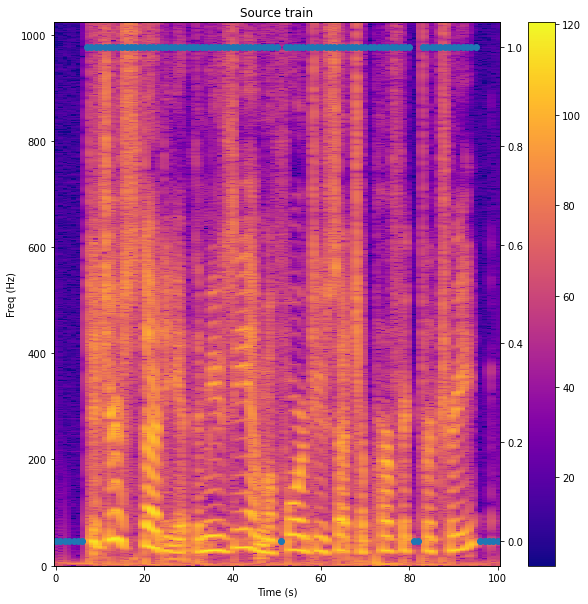

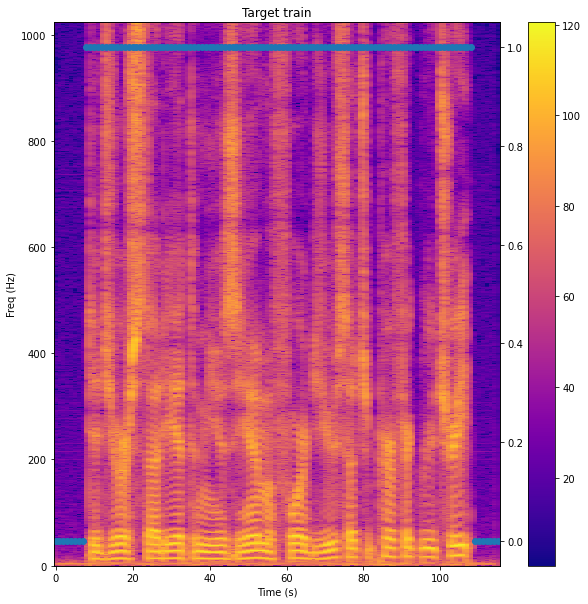

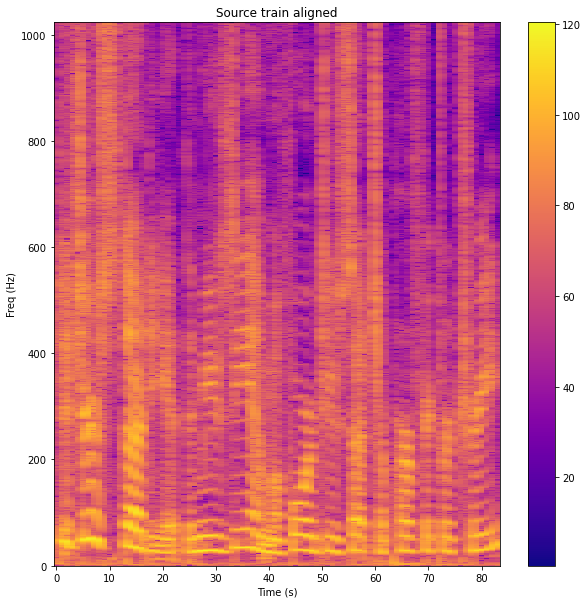

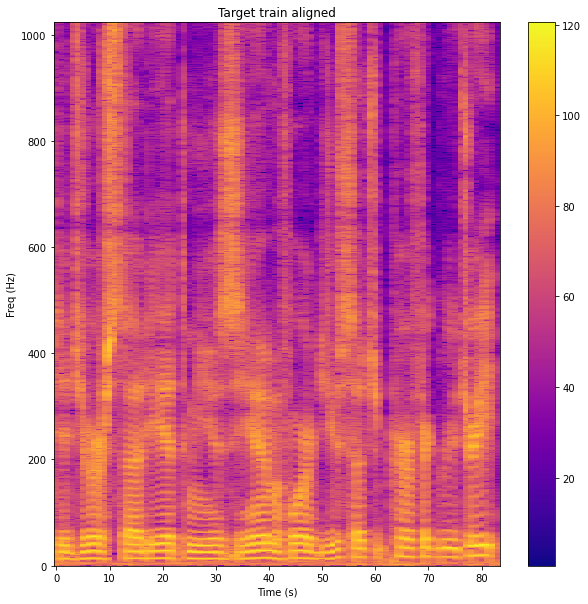

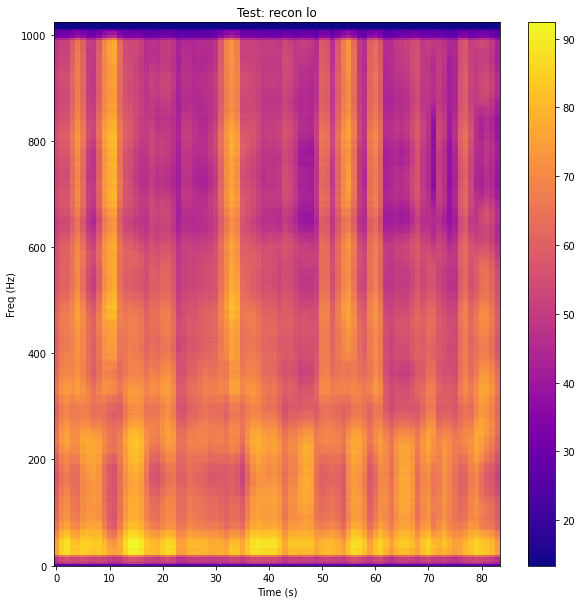

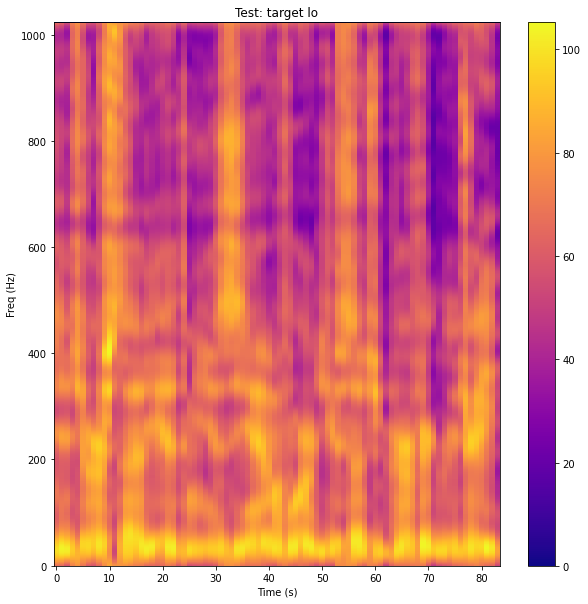

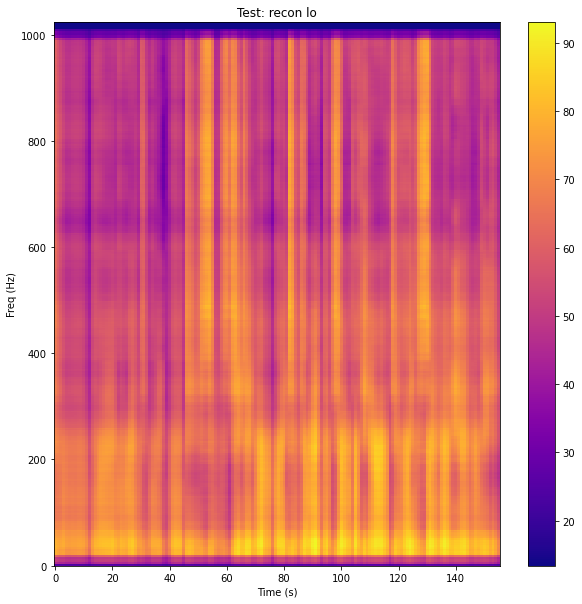

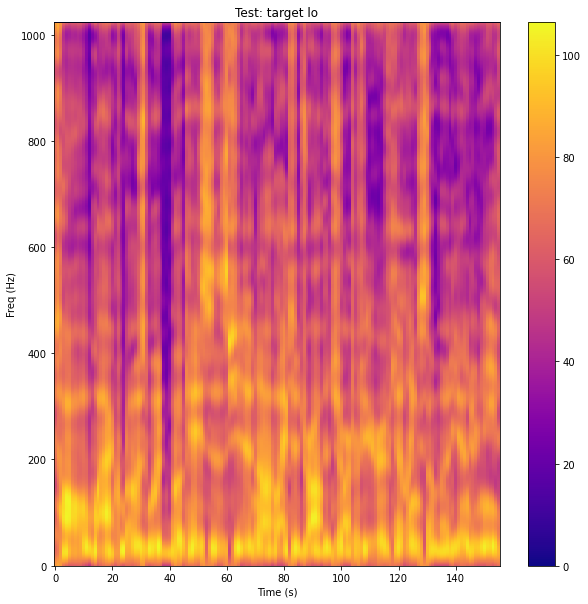

In [88]:
from models.split_model import SplitModelTaskDataset

def test_formant_transformer(model,
         train_source_filename, train_target_filename,
         test_input_filename, test_target_filename,
         second_train=False, vocode=True):
    def to_lo(log_amp):
        lo, hi = data.transform.dft_filter(log_amp)
        return lo
    def to_hi(log_amp):
        lo, hi = data.transform.dft_filter(log_amp)
        return hi
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)
    # raw audio
    task_dat = SplitModelTaskDataset(train_source_filename,
                                     train_target_filename)
    test_dat = SplitModelTaskDataset(test_input_filename, test_target_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')
    # aligned audio
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        aligned_1 = griffin_lim(amp_x_aligned)
        aligned_2 = griffin_lim(amp_y_aligned)
        sound(aligned_1, label='Source train aligned')
        sound(aligned_2, label='Target train aligned')
        sound((aligned_1+aligned_2)/2, label='Combined aligned')

    if second_train:
        # Generate task
        x, x_indices, y, y_indices = task_dat.get()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y = to_lo(x), to_lo(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        y = torch.from_numpy(y.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            y = formant_coder.encode(y)
        formant_transformer_optimizer_mgr.create_instance(model)
        train_formant_transformer(
            model, x, y,
            n_iter=200, log_period=20)

    def test_sample(test_task_dataset:SplitModelTaskDataset):
        from env import frame_size
        # Generate task
        x, x_indices, y, y_indices = test_task_dataset.get()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y_lo = to_lo(x), to_lo(y)
        y_hi = to_hi(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            x = formant_transformer.forward(x)
            x = formant_coder.decode(x)
            recon_lo = x.transpose(0,1).detach().cpu().numpy()
        plot_spec(recon_lo, title='Test: recon lo', figure_size=(10,10))
        plot_spec(y_lo, title='Test: target lo',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(db_to_amp(recon_lo+y_hi)),
                  label='Test: estimate')
            sound(griffin_lim(db_to_amp(y_lo+y_hi)), label='Test: target')
    if second_train:
        test_sample(task_dat)
    test_sample(test_dat)

source_speaker_id = 0
target_speaker_id = 3
train_audio_id = 3
test_audio_id = 5
test_formant_transformer(formant_transformer,
     meta_data.get(source_speaker_id, train_audio_id),
     meta_data.get(target_speaker_id, train_audio_id),
     meta_data.get(source_speaker_id, test_audio_id),
     meta_data.get(target_speaker_id, test_audio_id),
     second_train=True, vocode=True)

# Fundamental freq model
